# Symbolic regression without Parsimony Pressure or Hoist Muatation

## Testing various bloat control methods

This is the testing for the symbolic regression without the parsimony pressure.

In [1]:
#loading packages & dependencies
#When the %pylab magic function is entered at the IPython prompt, it triggers the import of various modules within Matplotlib.
%pylab inline 
from gplearnmod.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
from sympy import *
import matplotlib.pyplot as plt
import numpy as np
import graphviz

Populating the interactive namespace from numpy and matplotlib


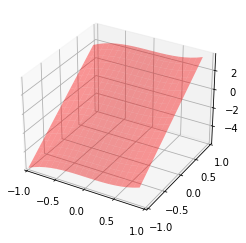

In [2]:
# Ground truth
x0 = np.arange(-1, 1, .1)
x1 = np.arange(-1, 1, .1)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**3+ 4*x1 - 0.75 #true function

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.arange(-1, 1.01, .5))
ax.set_yticks(np.arange(-1, 1.01, .5))
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, color='red', alpha=0.4)
plt.show()

In [3]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**3+ 4*X_train[:, 1] - 0.75

# Testing samples|
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**3+ 4*X_test[:, 1] - 0.75

In [4]:
est_gp = SymbolicRegressor(population_size=5000, #the number of programs in each generation
                           generations=50, stopping_criteria=0.01, #The required metric value required in order to stop evolution early.
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0, #0.05, The probability of performing hoist mutation on a tournament winner. Hoist mutation takes the winner of a tournament and selects a random subtree from it. A random subtree of that subtree is then selected and this is ‘hoisted’ into the original subtrees location to form an offspring in the next generation. This method helps to control bloat.
                           p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0, random_state=0)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          459.188       25         0.434331         0.506694      3.84m
   1    16.49          2.74763       51         0.240454         0.424414      2.41m
   2    19.54          2.49238       21         0.178287         0.169132      2.41m
   3    27.63          1.66685       25         0.163968          0.22371      2.67m
   4    29.23          1.47592       41         0.154723         0.212811      2.84m
   5    28.37          1.25387       25          0.13819         0.173492      2.72m
   6    28.28          1.38445       47         0.127865         0.278182      2.59m
   7    32.72          1.38447       29         0.114974         0.304576      2.51m
   8    34.82          1.04417       27        0.0759898          0.17471  

SymbolicRegressor(generations=50, max_samples=0.9, p_crossover=0.7,
                  p_hoist_mutation=0, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0,
                  population_size=5000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [5]:
print(est_gp._program)

sub(add(add(X1, X1), mul(mul(div(X1, X1), mul(X0, X0)), X0)), sub(0.752, add(X1, X1)))


In [6]:
sim = simplify(str(est_gp._program))
print(sim)

sub(add(add(X1, X1), mul(mul((1, 0), mul(X0, X0)), X0)), sub(0.752, add(X1, X1)))


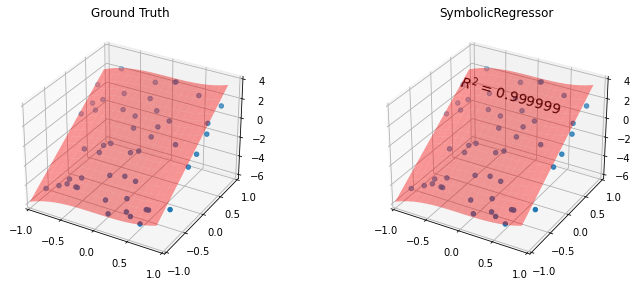

In [7]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
#y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
#score_tree = est_tree.score(X_test, y_test)
#y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
#score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor")]):
                                       #(y_tree, score_tree, "DecisionTreeRegressor"),
                                       #(y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(-1, 1.01, .5))
    ax.set_yticks(np.arange(-1, 1.01, .5))
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='red', alpha=0.4)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 0.1, .1, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)

plt.show()

# Conclusion

Just like the test without parsimony the program ended early at the 18 gen with even a much better accuracy at 0.9999 now that the hoist mutation have been disabled. We came into the conclusion that while bloat control method such as parismony pressure and the hoist muation manage to keep the program small, it also destropy good building blocks necessary for the evolution